In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()
from keras.layers import Input, Flatten, Dense,Dropout, Lambda, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Activation 
from keras.models import Model
from keras import objectives
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

Using TensorFlow backend.


In [2]:
flowers = [flower for flower in os.listdir('flowers/')]

In [3]:
flowers

['tulip', 'dandelion', 'daisy', 'rose', 'sunflower']

In [4]:
def load(flower):
    path_to_data = 'flowers/'+flower+'/'
    files = [file for file in os.listdir(path_to_data)]
    images = [cv2.imread(path_to_data + file) for file in files]
    images = [cv2.resize(img, (64, 64)) for img in images if img is not None]
    print('number of images of type {}:'.format(flower), len(images))
    labels = [flower]*len(images)
    return images, labels

In [5]:
data, labels= [], []
for i in tqdm(flowers):
    imgs = load(i)
    data += imgs[0] 
    labels += imgs[1]

number of images of type tulip: 984
number of images of type dandelion: 1052
number of images of type daisy: 769
number of images of type rose: 784
number of images of type sunflower: 734



In [6]:
data = np.array(data,dtype='float64') / 255.0

In [7]:
labels = pd.Series(labels).astype('category').cat.codes.values
labels = np.array(labels)
print(data.shape, labels.shape)

(4323, 64, 64, 3) (4323,)


In [10]:
(train_x, test_x, train_y, test_y) = train_test_split(data, labels, test_size=0.2, random_state=42)

In [11]:
train_y = to_categorical(train_y, num_classes=5)
test_y = to_categorical(test_y, num_classes=5)

In [12]:
train_x.shape, train_y.shape

((3458, 64, 64, 3), (3458, 5))

In [13]:
EPOCHS = 30
BS = 64

In [18]:
model = Sequential()
classes = 5
inputShape = (64, 64, 3)

model.add(Conv2D(64, (5, 5), padding="same", input_shape=inputShape))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(128, (5, 5), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(256, (5, 5), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(512, (5, 5), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Flatten())
model.add(Dense(128,name='Dense_1'))
model.add(Activation("relu"))
model.add(Dropout(0.2))

# softmax classifier
model.add(Dense(classes,name='Dense_2'))
model.add(Activation("softmax"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 64, 64, 64)        4864      
_________________________________________________________________
activation_7 (Activation)    (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 128)       204928    
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 128)       0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 256)       819456    
__________

In [19]:
model.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics=["accuracy"])

In [ ]:
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")

H = model.fit_generator(aug.flow(train_x, train_y, batch_size=BS), steps_per_epoch=len(train_x) // BS,
    epochs=EPOCHS,callbacks = [EarlyStopping(monitor='val_loss',patience = 5)], verbose=1)

Epoch 1/30
54/54 [==============================] - 278s 5s/step - loss: 1.9461 - acc: 0.2486
Epoch 2/30


/home/houssem/anaconda2/envs/mypy3/lib/python3.4/site-packages/keras/callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: acc,loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


20/54 [==========>...................] - ETA: 2:42 - loss: 1.5098 - acc: 0.3078

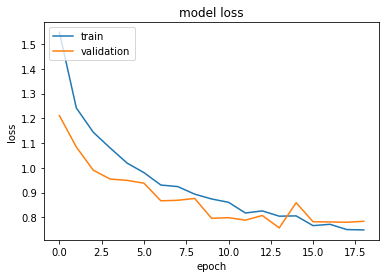

In [31]:
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()    

In [40]:
predictions = model.predict(test_x)

In [41]:
acc = sum([np.argmax(test_y[i])==np.argmax(predictions[i]) for i in range(865)])/865
acc

0.5699421965317919